In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uncertainty_tools
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.stats import norm
import datetime

In [37]:
wind = pd.read_csv('US_capacity_wind_25pctTop_unnormalized.csv', header=5)
solar = pd.read_csv('US_capacity_solar_25pctTop_unnormalized.csv', header=5)
dem = pd.read_csv('US_demand_unnormalized.csv', header=8)

dem['demand'] = dem['demand'] / np.mean(dem['demand'])

def add_datetime(df):
    
    dt_list = []
    for idx in df.index:
        dt = datetime.datetime(df.loc[idx, 'year'], df.loc[idx, 'month'], df.loc[idx, 'day'], df.loc[idx, 'hour']-1)
        dt_list.append(dt)
        
    
    df['date_time'] = dt_list
    return df


dem = add_datetime(dem)
wind = add_datetime(wind)
solar = add_datetime(solar)

print(wind.head())
print(solar.head())
print(dem.head())



   year  month  day  hour      wind           date_time
0  2015      8    1     1  0.174281 2015-08-01 00:00:00
1  2015      8    1     2  0.275520 2015-08-01 01:00:00
2  2015      8    1     3  0.367695 2015-08-01 02:00:00
3  2015      8    1     4  0.397200 2015-08-01 03:00:00
4  2015      8    1     5  0.386158 2015-08-01 04:00:00
   year  month  day  hour     solar           date_time
0  2015      8    1     1  0.305370 2015-08-01 00:00:00
1  2015      8    1     2  0.129735 2015-08-01 01:00:00
2  2015      8    1     3  0.007222 2015-08-01 02:00:00
3  2015      8    1     4  0.000000 2015-08-01 03:00:00
4  2015      8    1     5  0.000000 2015-08-01 04:00:00
   year  month  day  hour    demand           date_time
0  2015      8    1     1  1.346185 2015-08-01 00:00:00
1  2015      8    1     2  1.299755 2015-08-01 01:00:00
2  2015      8    1     3  1.234337 2015-08-01 02:00:00
3  2015      8    1     4  1.150697 2015-08-01 03:00:00
4  2015      8    1     5  1.074282 2015-08-01 0

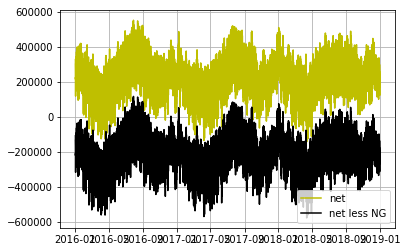

In [4]:
mean_dem = np.mean(dem['demand (MW)'])
ng_scale = 0.783068188 # rel 0.01, tests_Jul25_v1_20190725_230835
ng_scale = 0.962410549145009 # rel 0.001, tests_Jul25_v1_20190725_230444
fig, ax = plt.subplots()
net_dem = dem['demand (MW)'].values - (wind['wind capacity'].values + solar['solar capacity'].values)*mean_dem
ax.plot(dem['date'], net_dem, 'y-', label='net')
net_less_ng = net_dem - ng_scale * mean_dem
ax.plot(dem['date'], net_less_ng, 'k-', label='net less NG')
plt.legend()
plt.grid()
plt.show()

In [5]:
print("Total dem: {:.1f} (GWh)".format(sum(dem['demand (MW)'])/1000.))
lol = 0.
for val in net_less_ng:
    if val > 0:
        lol += val
print("Total LOL: {:.1f} (GWh)".format(lol/1000.))
print("Unmet fraction: {:.4f}".format(lol/sum(dem['demand (MW)'])))

Total dem: 11919533.8 (GWh)
Total LOL: 17348.2 (GWh)
Unmet fraction: 0.0015


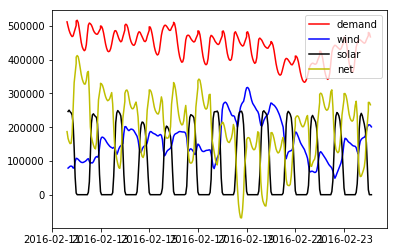

In [6]:
fig, ax = plt.subplots()
st = 1000
dlt = 300
ax.plot(dem['date'][st:st+dlt], dem['demand (MW)'][st:st+dlt], 'r-', label='demand')
#ax.plot(dem['date'], dem['fourtyEight'], 'b-')
ax.plot(wind['date'][st:st+dlt], wind['wind capacity'][st:st+dlt]*mean_dem, 'b-', label='wind')
ax.plot(solar['date'][st:st+dlt], solar['solar capacity'][st:st+dlt]*mean_dem, 'k-', label='solar')
net_dem = dem['demand (MW)'].values - (wind['wind capacity'].values + solar['solar capacity'].values)*mean_dem
ax.plot(dem['date'][st:st+dlt], net_dem[st:st+dlt], 'y-', label='net')
plt.legend()
plt.show()

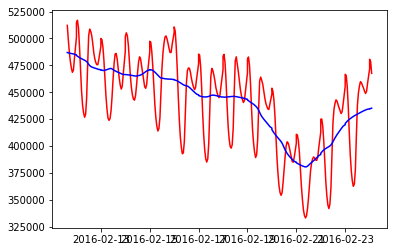

In [7]:
fig, ax = plt.subplots()
ax.plot(dem['date'][1000:1300], dem['demand (MW)'][1000:1300], 'r-')
ax.plot(dem['date'][1000:1300], dem['fourtyEight'][1000:1300], 'b-')
plt.show()

In [8]:
for i in range(0, 100, 5):
    print(i, "percentile", np.percentile(dem['demand (MW)'], i))

0 percentile 271856.0
5 percentile 349796.75
10 percentile 367112.0
15 percentile 380437.0
20 percentile 391536.0
25 percentile 401714.0
30 percentile 411159.0
35 percentile 420053.1
40 percentile 428242.39999999997
45 percentile 435381.44999999995
50 percentile 443020.5
55 percentile 449914.0
60 percentile 457632.6
65 percentile 467214.4
70 percentile 477856.4
75 percentile 491321.75
80 percentile 509003.0
85 percentile 530207.8500000001
90 percentile 558289.8
95 percentile 597988.0499999999


In [16]:
def normalize_rows(transitions):
    print("pre norm",transitions)
    for row in transitions:
        row = row/row.sum()
    print("post norm",transitions)


# Markov transition matrix for state system.
# Initial state is set by first time slice.
# Transitions are analyzed for n-1 time steps.
def print_markov_state_probs(vals, thresholds):

    # Transitions matrix for recording each hour-to-hour transition
    transitions = np.zeros((len(thresholds)+1, len(thresholds)+1))


    prev = 0
    prev = uncertainty_tools.get_state(vals[0], thresholds)
    current = 0
    tot = 0
    for i in range(1, len(vals)):
        val = vals[i]
        current = uncertainty_tools.get_state(val, thresholds)
        transitions[prev][current] += 1
        prev = current
        tot += 1

    print ("Vals length {:d}, Total recorded transitions {:d}\n".format(len(vals), tot))
    print(transitions,"\n")
    
    normalize_rows(transitions)

    alpha = float(transitions[0][1]/(transitions[0][1]+transitions[0][0]))
    beta = float(transitions[1][0]/(transitions[1][1]+transitions[1][0]))

    P = np.array([[1-alpha, alpha], [beta, 1-beta]])
    print(P,"\n")



variable = 'demand (MW)'
thresholds = [99.9, 99.95, 99.99]
thresholds = [50,]# 90, 95, 99, 99.9, 99.97, 99.99]
#thresholds = [0.1, 0.01, 0.003, 0.001]
for val in thresholds:
    print(val)
    #uncertainty_tools.print_markov_2_state_probs(dem[variable], np.percentile(dem[variable], val))
    uncertainty_tools.print_markov_2_state_probs(net_less_ng, np.percentile(net_less_ng, val))
    print_markov_state_probs(net_less_ng, [np.percentile(net_less_ng, val),])



50
success_to_success 11992 0.4559002433090024
success_to_fail 1160 0.04409975669099757
fail_to_success 1160 0.04409975669099757
fail_to_fail 11992 0.4559002433090024
Total 1.000000, both fails 0.500000

[[11992  1160]
 [ 1160 11992]] 

[[0.91180049 0.08819951]
 [0.08819951 0.91180049]] 

Vals length 26304, Total recorded transitions 26303

[[11992.  1159.]
 [ 1160. 11992.]] 

[[0.91186982 0.08813018]
 [0.08819951 0.91180049]] 



In [ ]:
# States are defined as 0 fail, 1 success
def sim_Markov_2_state(matrix, init_val, reps, seed=1):
    assert(init_val == 0 or init_val ==1)
    
    if seed%100==0: print(seed)
    
    states = []
    
    #print("Using Markov transition matrix:")
    #print(matrix)
    
    np.random.seed(seed)
    
    prev_val = init_val
    for i in range(reps):
        rand = np.random.uniform(0,1,1)[0]
        if rand > P[prev_val][prev_val]:
            #print("transition!",rand, P[prev_val][prev_val])
            if prev_val == 0:
                prev_val = 1
            elif prev_val == 1:
                prev_val = 0
            #print("Now in state {}".format(prev_val))
        states.append(prev_val)
    return states

def analyze_2_state_states(states):
    #print("Average state {:.3f}".format(np.mean(states)))
    trans_up = 0
    trans_down = 0
    trans = 0
    prev = states[0]
    for i in range(1, len(states)):
        if states[i] != prev:
            trans += 1
            if prev == 0:
                trans_up += 1
            if prev == 1:
                trans_down += 1
            prev = states[i]
    #print("Transitions: {}".format(trans))
    #print("Transitions Up: {}".format(trans_up))
    #print("Transitions Down: {}".format(trans_down))
    
    time_up = np.mean(states)*len(states)
    #print("Time Up: {} hours".format(time_up))
    #if trans_up > 0.:
    #    print("Avg Time Up: {} hours".format( (np.mean(states)*len(states))/trans_up ) )
    return trans_up, time_up


year = 8760
threshold = 99.9
reps = 500
for threshold in [99, 99.9, 99.97]:
    trans_up = []
    time_up = []
    for seed in range(reps):
        M, P = uncertainty_tools.print_markov_2_state_probs(net_less_ng, np.percentile(net_less_ng, threshold))
        states = sim_Markov_2_state(P, 0, year, seed)
        info = analyze_2_state_states(states)
        trans_up.append(info[0])
        time_up.append(info[1])

   
    

    
    range_ = [i for i in range(0, max(trans_up)+5)]
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(trans_up, range_, alpha=0.5, ec='black', density=1)
    fit = norm.fit(trans_up)
    ax.plot(range_, norm(fit[0], fit[1]).pdf(range_), '--')
    plt.savefig("rel_threshold_{}_trans_up.png".format(str(round(threshold,2)).replace('.','p')))
    
    print("Number of trans_up: {:d}   avg: {:.3f}".format(len(trans_up), np.mean(trans_up)))
    for pct in [5, 25, 50, 75, 95]:
        print("Percentiles - {:d} = {:.2f}".format(pct, np.percentile(trans_up, pct)))
    
    range_ = [i for i in range(0, int(max(time_up))+5)]
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(time_up, range_, alpha=0.5, ec='black', density=1)
    fit = norm.fit(time_up)
    ax.plot(range_, norm(fit[0], fit[1]).pdf(range_), '--')
    plt.savefig("rel_threshold_{}_time_up.png".format(str(round(threshold,2)).replace('.','p')))
    
    print("\nNumber of time_up: {:d}   avg: {:.3f}".format(len(time_up), np.mean(time_up)))
    for pct in [5, 25, 50, 75, 95]:
        print("Percentiles - {:d} = {:.2f}".format(pct, np.percentile(time_up, pct)))

#fig, ax = plt.subplots(figsize=(15,2))
#ax.plot(range(0, len(states)), states, 'k-', label='net less NG')
#plt.show()